In [1]:
import os
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
npy_file_dir = rf'D:\project\code\from_git\image-to-3d-tradition-sfm\3DGS\2d-gaussian-splatting-main_self\tools\npy_points_colors'

points_list = []
colors_list = []
for file in os.listdir(npy_file_dir):
    if file.endswith('.npy'):
        points = np.load(os.path.join(npy_file_dir, file), allow_pickle=True).item()['points']
        colors = np.load(os.path.join(npy_file_dir, file), allow_pickle=True).item()['colors']
        points_list.append(points)
        colors_list.append(colors)

points_all = np.concatenate(points_list, axis=0)
colors_all = np.concatenate(colors_list, axis=0)

## 只展示损伤（所有损伤）

In [3]:
# open3d展示

import open3d as o3d
import numpy as np
import os

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_all)
pcd.colors = o3d.utility.Vector3dVector(colors_all)

# 显示点云
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
vis.get_render_option().point_size = 2.0
vis.get_render_option().background_color = np.asarray([0, 0, 0])

vis.run()
vis.destroy_window()

### 展示某个损伤(这里crack_name的16-18对应13-15)

In [98]:
crack_name = '0032_1_16.npy'
npy_file_crack_dir = rf'D:\project\code\from_git\image-to-3d-tradition-sfm\3DGS\2d-gaussian-splatting-main_self\tools\npy_points_colors'

crack_points_list = []
crack_colors_list = []

crack_points = np.load(os.path.join(npy_file_crack_dir, crack_name), allow_pickle=True).item()['points']
crack_colors = np.load(os.path.join(npy_file_crack_dir, crack_name), allow_pickle=True).item()['colors']

crack_points_np = np.array(crack_points)
crack_colors_np = np.array(crack_colors)

print(crack_points_np.shape)

(1656, 3)


In [99]:
# open3d展示

import open3d as o3d
import numpy as np
import os

pcd_crack = o3d.geometry.PointCloud()
pcd_crack.points = o3d.utility.Vector3dVector(crack_points_np)
pcd_crack.colors = o3d.utility.Vector3dVector(crack_colors_np)

# 显示点云
vis_crack = o3d.visualization.Visualizer()
vis_crack.create_window()
vis_crack.add_geometry(pcd_crack)
vis_crack.get_render_option().point_size = 2.0
# vis_crack.get_render_option().background_color = np.asarray([0, 0, 0])
vis_crack.get_render_option().background_color = np.asarray([1, 1, 1])

vis_crack.run()
vis_crack.destroy_window()

### 展示crack的对称点，用于计算宽度

In [100]:
crack_pair_name = '0032_1_13'
cls_name = int(crack_pair_name.split('_')[1])
sample_name = int(crack_pair_name.split('_')[2])

crack_pair_npy_dir = rf"D:\doc\博士阶段\成果\1论文\2024-2025\1\images\chapter2\dalian_xinghaiwandaqiao_video_input_rgba_txt_file_camera_crop_OPTICS_lambda_dist=100\outputs\npy_cls_pair_points_colors\{crack_pair_name}.npy"

crack_pair_points_list = []
crack_pair_colors_list = []

print(np.load(crack_pair_npy_dir, allow_pickle=True).item().keys())
crack_pair_points = np.load(crack_pair_npy_dir, allow_pickle=True).item()['points']
# crack_pair_colors = np.load(crack_pair_npy_dir, allow_pickle=True).item()['colors']
# crack_pair_colors设置为和crack_pair_points一样形状的红色
crack_pair_colors = np.zeros_like(crack_pair_points) + [0.5, 0, 0]
# print(crack_pair_points.shape)
# print(crack_pair_colors.shape)

crack_pair_points_np = np.array(crack_pair_points)
crack_pair_colors_np = np.array(crack_pair_colors)

print(crack_pair_points_np.shape, crack_pair_points_np)

dict_keys(['points', 'colors'])
(643, 3) [[1.00783955 0.89202238 4.94429758]
 [1.00481541 0.89430581 4.94718856]
 [1.0030856  0.89652363 4.9484171 ]
 ...
 [1.06116883 1.02371427 4.84161849]
 [1.04203174 1.02748164 4.88185567]
 [1.04283824 1.02739719 4.87987158]]


In [101]:
# open3d展示

import open3d as o3d
import numpy as np
import os

pcd_crack_pair = o3d.geometry.PointCloud()
pcd_crack_pair.points = o3d.utility.Vector3dVector(crack_pair_points_np)
pcd_crack_pair.colors = o3d.utility.Vector3dVector(crack_pair_colors_np)

# 显示点云
vis_crack_pair = o3d.visualization.Visualizer()
vis_crack_pair.create_window()
vis_crack_pair.add_geometry(pcd_crack_pair)
vis_crack_pair.get_render_option().point_size = 2.0
# vis_crack_pair.get_render_option().background_color = np.asarray([0, 0, 0])
vis_crack_pair.get_render_option().background_color = np.asarray([1, 1, 1])

# 存储点云
# save_point_pair_dir = "output_crack_pair"
# os.makedirs(save_point_pair_dir, exist_ok=True)
# o3d.io.write_point_cloud(os.path.join(save_point_pair_dir, rf"crack_pair_{crack_pair_name}.ply"), pcd_crack_pair)
vis_crack_pair.run()
vis_crack_pair.destroy_window()

## L1算法提取骨架：

https://blog.csdn.net/u012901740/article/details/144107523

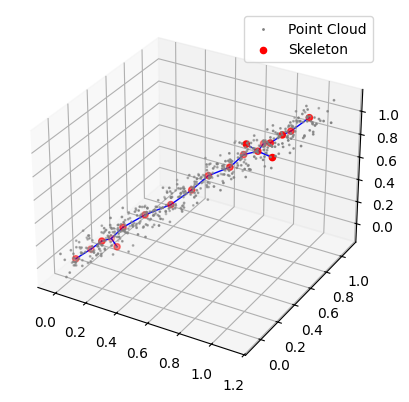

In [8]:
import numpy as np 
from scipy.spatial import distance 
from scipy.sparse.csgraph import minimum_spanning_tree

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 


def extract_l1_skeleton(point_cloud, num_seeds=10, epsilon=0.01, max_iterations=100):

    """
    提取点云的L1骨架。 
    
    参数:
        point_cloud (ndarray): 输入点云数据 (n, 3) 
        num_seeds (int): 初始骨架点数量
        epsilon (float): 收敛阈值
        max_iterations (int): 最大迭代次数
    
    返回:
        skeleton_points (ndarray): 提取的骨架点 (m, 3)
    """
    # 初始化骨架点 (随机选择点云中的一些点)
    np.random.seed(42)
    indices = np.random.choice(point_cloud.shape[0], num_seeds, replace=False)
    skeleton_points = point_cloud[indices]
    
    for iteration in range(max_iterations):
        # 分配吸引关系：计算每个点到骨架点的最近距离
        distances = distance.cdist(point_cloud, skeleton_points, metric='cityblock')  # L1距离
        nearest_indices = np.argmin(distances, axis=1)  # 每个点的最近骨架点索引
        
        # 更新骨架点：计算每个骨架点的几何中位数
        new_skeleton_points = []
        for j in range(num_seeds):
            assigned_points = point_cloud[nearest_indices == j]
            if len(assigned_points) > 0:
                median = np.median(assigned_points, axis=0)
                new_skeleton_points.append(median)
        new_skeleton_points = np.array(new_skeleton_points)
        
        # 检查收敛条件：骨架点的移动是否小于阈值
        movement = np.linalg.norm(new_skeleton_points - skeleton_points, ord=1, axis=1).max()
        skeleton_points = new_skeleton_points
        if movement < epsilon:
            break

    return skeleton_points


def sparsify_skeleton(skeleton_points, min_distance=0.05):
    """
    稀疏化骨架点，移除距离小于指定阈值的点。
    
    参数:
        skeleton_points (ndarray): 骨架点集合 (m, 3)
        min_distance (float): 最小距离阈值
    
    返回:
        sparse_skeleton (ndarray): 稀疏化后的骨架点
    """
    sparse_skeleton = []
    for point in skeleton_points:
        if all(distance.cityblock(point, p) > min_distance for p in sparse_skeleton):
            sparse_skeleton.append(point)
    return np.array(sparse_skeleton)


def connect_skeleton_points_with_mst(skeleton_points):
    """
    使用最小生成树 (MST) 生成骨架点的连接线。
    
    参数:
        skeleton_points (ndarray): 骨架点集合 (m, 3)
    
    返回:
        lines (list of tuples): 每一对连接点的索引
    """
    # 计算骨架点之间的欧几里得距离矩阵
    dist_matrix = distance.cdist(skeleton_points, skeleton_points, metric='euclidean')
    
    # 构建最小生成树
    mst = minimum_spanning_tree(dist_matrix)
    
    # 提取MST的连接关系
    connections = np.array(mst.nonzero()).T  # 非零元素为连接关系
    return [(i, j) for i, j in connections]


def visualize_point_cloud_and_skeleton(point_cloud, skeleton_points, connections=None):
    """
    可视化点云、骨架点和骨架连线。
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], c='gray', s=1, label="Point Cloud")
    ax.scatter(skeleton_points[:, 0], skeleton_points[:, 1], skeleton_points[:, 2], c='red', s=20, label="Skeleton")

    # 绘制骨架连线
    if connections:
        for (i, j) in connections:
            p1 = skeleton_points[i]
            p2 = skeleton_points[j]
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], c='blue', linewidth=1)

    ax.legend()
    plt.show()


# 主程序
if __name__ == "__main__":
    # 生成接近直线的点云数据
    np.random.seed(42)
    num_points = 500

    # 基础直线：从 (0, 0, 0) 到 (1, 1, 1)
    t = np.linspace(0, 1, num_points)
    line = np.array([t, t, t]).T  # 直线数据

    # 添加随机噪声
    noise = np.random.normal(scale=0.05, size=(num_points, 3))  # 控制噪声强度
    point_cloud = line + noise

    # 提取骨架
    skeleton_points = extract_l1_skeleton(point_cloud, num_seeds=20, epsilon=0.01, max_iterations=100)

    # 稀疏化骨架
    sparse_skeleton = sparsify_skeleton(skeleton_points, min_distance=0.05)

    # 生成骨架点连接线（使用MST）
    connections = connect_skeleton_points_with_mst(sparse_skeleton)

    # 可视化结果
    visualize_point_cloud_and_skeleton(point_cloud, sparse_skeleton, connections)



Skeleton points: (50, 3)
Sparse skeleton points: (50, 3)


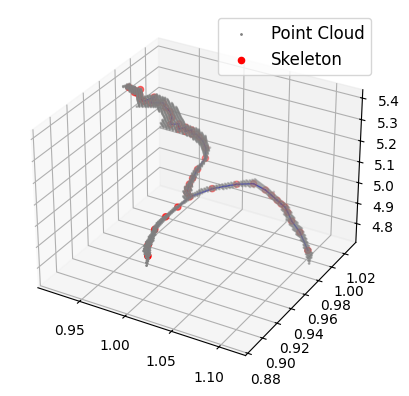

In [102]:
# 主程序
if __name__ == "__main__":
    # 生成接近直线的点云数据
    np.random.seed(42)
    # num_points = 500

    # # 基础直线：从 (0, 0, 0) 到 (1, 1, 1)
    # t = np.linspace(0, 1, num_points)
    # line = np.array([t, t, t]).T  # 直线数据

    # # 添加随机噪声
    # noise = np.random.normal(scale=0.05, size=(num_points, 3))  # 控制噪声强度
    # point_cloud = crack_pair_points_np
    point_cloud = crack_points_np

    # 提取骨架
    skeleton_points = extract_l1_skeleton(point_cloud, num_seeds=50, epsilon=0.01, max_iterations=100)
    print("Skeleton points:", skeleton_points.shape)
    # 稀疏化骨架
    sparse_skeleton = sparsify_skeleton(skeleton_points, min_distance=0.001)
    print("Sparse skeleton points:", sparse_skeleton.shape)

    # 生成骨架点连接线（使用MST）
    connections = connect_skeleton_points_with_mst(sparse_skeleton)
    # connections = connect_skeleton_points_with_mst(skeleton_points)

    # 可视化结果
    visualize_point_cloud_and_skeleton(point_cloud, sparse_skeleton, connections)


    # np.save(os.path.join(save_npy_dir,'skeleton_points.npy'), skeleton_points)


In [103]:
save_npy_dir = rf'output_crack_pair/edge_points_and_skelton_points_npy'
os.makedirs(save_npy_dir, exist_ok=True)
points_and_skelton_dict = {'edge_points': crack_pair_points_np,'skeleton_points': skeleton_points}
np.save(os.path.join(save_npy_dir, rf'{crack_pair_name}.npy'), points_and_skelton_dict)

In [104]:
# 展示裂缝的sparse_skeleton和crack_pair_points_np在open3d中显示的效果

# open3d展示

import open3d as o3d
import numpy as np
import os

pcd_crack_pair = o3d.geometry.PointCloud()
pcd_crack_pair.points = o3d.utility.Vector3dVector(crack_pair_points_np)
pcd_crack_pair.colors = o3d.utility.Vector3dVector(crack_pair_colors_np)

pcd_crack_sparse_skeleton = o3d.geometry.PointCloud()
pcd_crack_sparse_skeleton.points = o3d.utility.Vector3dVector(sparse_skeleton)
# 设置统一为绿色
skeleton_colors = np.zeros((sparse_skeleton.shape[0], 3))
skeleton_colors[:, 1] = 0.5
pcd_crack_sparse_skeleton.colors = o3d.utility.Vector3dVector(skeleton_colors)
# pcd_crack_sparse_skeleton.colors = o3d.(np.array([0, 0.5, 0]))

# 显示点云
vis_crack_pair_skeleton = o3d.visualization.Visualizer()
vis_crack_pair_skeleton.create_window()
vis_crack_pair_skeleton.add_geometry(pcd_crack_pair)
vis_crack_pair_skeleton.add_geometry(pcd_crack_sparse_skeleton)
vis_crack_pair_skeleton.get_render_option().point_size = 5.0
# vis_crack_pair_skeleton.get_render_option().background_color = np.asarray([0, 0, 0])
vis_crack_pair_skeleton.get_render_option().background_color = np.asarray([1, 1, 1])

# 存储点云
# save_point_pair_dir = "output_crack_pair"
# os.makedirs(save_point_pair_dir, exist_ok=True)
# o3d.io.write_point_cloud(os.path.join(save_point_pair_dir, rf"crack_pair_{crack_pair_name}.ply"), pcd_crack_pair)
vis_crack_pair_skeleton.run()
vis_crack_pair_skeleton.destroy_window() 

### 计算骨架点的最近点

点集类型: clustered, 点数: 148, 目标点: [ 0.2 -0.1  0.3]
最近点: [ 0.13949708 -0.41767353  0.07257456], 距离: 0.3953
距线最近点: [0.65404597 0.97720699 1.12166972], 距离: 0.2449

        === 三维点集分析报告 ===
        
        目标点坐标: (0.2000, -0.1000, 0.3000)
        
        最近点分析:
          最近点坐标: (0.1395, -0.4177, 0.0726)
          到目标点距离: 0.3953
        
        延长线分析:
          方向向量: (-0.1530, -0.8035, -0.5753)
          延长线长度: 8.00
        
        距线最近点分析:
          最近点坐标: (0.6540, 0.9772, 1.1217)
          到延长线距离: 0.2449
          垂足坐标: (0.4154, 1.0311, 1.1098)
          垂直距离: 0.2449
        


C:\Users\1\AppData\Local\Temp\ipykernel_24996\196180607.py:168: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\1\AppData\Local\Temp\ipykernel_24996\196180607.py:168: UserWarning: Glyph 32500 (\N{CJK UNIFIED IDEOGRAPH-7EF4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\1\AppData\Local\Temp\ipykernel_24996\196180607.py:168: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\1\AppData\Local\Temp\ipykernel_24996\196180607.py:168: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\1\AppData\Local\Temp\ipykernel_24996\196180607.py:168: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\1\AppData\Local\Temp\ipykernel_24996\196180607.py:168: UserWarning: Glyph 26512 (\N{CJK UNIFIED IDEOGRAPH-

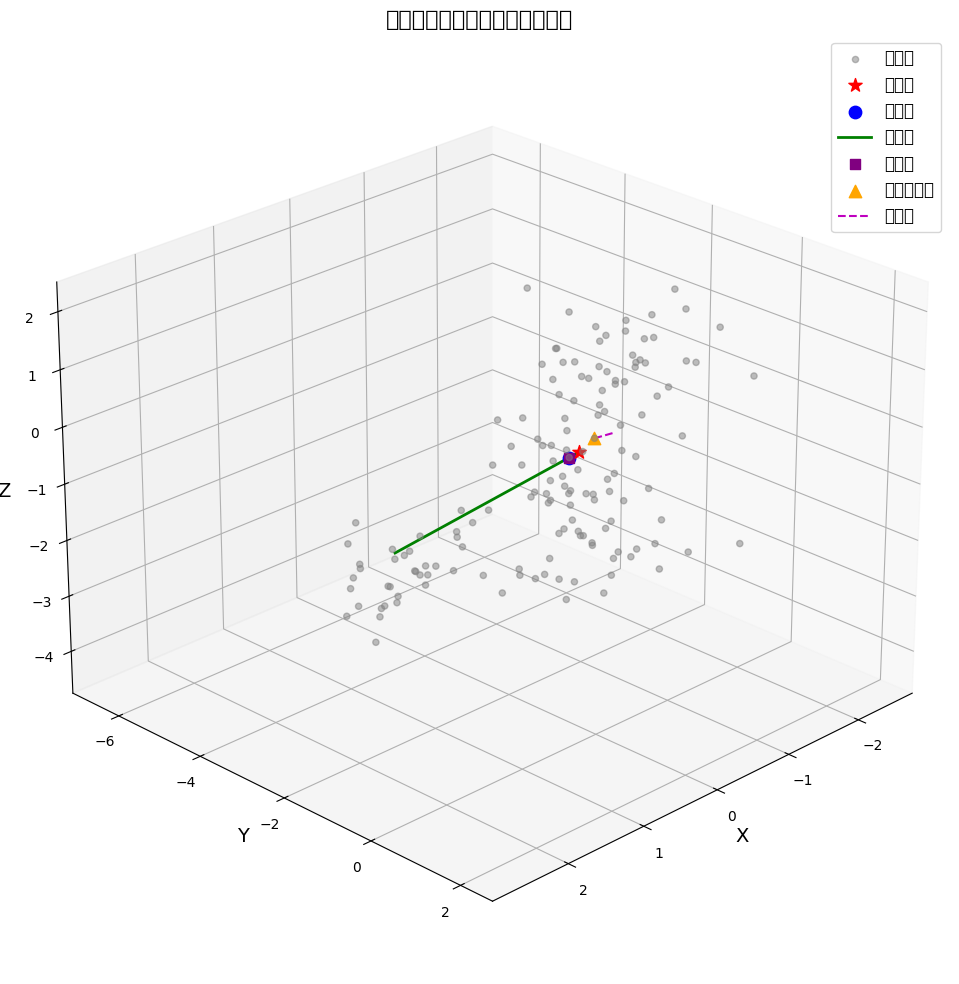

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import KDTree
from scipy.optimize import minimize
import matplotlib as mpl

# 设置全局绘图参数
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 12

class PointLineAnalyzer:
    def __init__(self, points, target_point, extension_length=10.0):
        """
        初始化点线分析器
        :param points: 三维点集，形状为(N, 3)的numpy数组
        :param target_point: 目标点，形状为(3,)的numpy数组
        :param extension_length: 延长线的长度
        """
        self.points = np.asarray(points, dtype=np.float64)
        self.target_point = np.asarray(target_point, dtype=np.float64)
        self.extension_length = extension_length
        self.closest_point = None
        self.line_direction = None
        self.line_points = None
        self.line_point = None
        self.nearest_to_line = None
        self.distances = None
        
        # 验证输入
        if self.points.shape[0] < 2:
            raise ValueError("点集至少需要包含2个点")
        if self.points.shape[1] != 3:
            raise ValueError("点集必须是三维坐标")
        if self.target_point.shape != (3,):
            raise ValueError("目标点必须是三维坐标")
    
    def find_closest_point(self):
        """找到距离目标点最近的点"""
        # 使用KDTree进行最近邻搜索
        tree = KDTree(self.points)
        
        # 查询最近点
        distance, index = tree.query(self.target_point)
        self.closest_point = self.points[index]
        
        return self.closest_point, distance
    
    def create_extension_line(self):
        """创建延长线"""
        if self.closest_point is None:
            self.find_closest_point()
        
        # 计算方向向量
        self.line_direction = self.closest_point - self.target_point
        direction_norm = np.linalg.norm(self.line_direction)
        
        # 避免零向量
        if direction_norm < 1e-10:
            self.line_direction = np.array([1.0, 0.0, 0.0])  # 默认方向
        else:
            self.line_direction = self.line_direction / direction_norm
        
        # 创建延长线点集
        t = np.linspace(0, self.extension_length, 100)
        self.line_points = np.outer(t, self.line_direction) + self.target_point
        
        # 计算延长线上最接近目标点的点（即原始最近点）
        t_closest = np.dot(self.closest_point - self.target_point, self.line_direction)
        self.line_point = self.target_point + t_closest * self.line_direction
        
        return self.line_points
    
    def find_nearest_to_line(self, exclude_points=True):
        """找到距离延长线最近的点"""
        if self.line_points is None:
            self.create_extension_line()
        
        # 准备要排除的点索引
        exclude_indices = []
        if exclude_points:
            # 找到目标点和最近点在点集中的索引
            target_index = np.argmin(np.linalg.norm(self.points - self.target_point, axis=1))
            closest_index = np.argmin(np.linalg.norm(self.points - self.closest_point, axis=1))
            exclude_indices = [target_index, closest_index]
        
        # 计算所有点到直线的距离
        self.distances = np.zeros(len(self.points))
        for i, point in enumerate(self.points):
            if i in exclude_indices:
                self.distances[i] = np.inf  # 排除点
            else:
                # 计算点到直线的距离
                vec_to_target = point - self.target_point
                projection = np.dot(vec_to_target, self.line_direction)
                perpendicular = vec_to_target - projection * self.line_direction
                self.distances[i] = np.linalg.norm(perpendicular)
        
        # 找到距离最近的点
        min_idx = np.argmin(self.distances)
        self.nearest_to_line = self.points[min_idx]
        
        return self.nearest_to_line, self.distances[min_idx]
    
    def visualize(self, show_all_points=True):
        """可视化结果"""
        fig = plt.figure(figsize=(14, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # 设置视角
        ax.view_init(elev=25, azim=45)
        
        # 绘制所有点
        if show_all_points:
            ax.scatter(self.points[:, 0], self.points[:, 1], self.points[:, 2], 
                      c='gray', s=20, alpha=0.5, label='所有点')
        
        # 标记目标点
        ax.scatter(self.target_point[0], self.target_point[1], self.target_point[2],
                  c='red', s=100, marker='*', label='目标点')
        
        # 标记最近点
        if self.closest_point is not None:
            ax.scatter(self.closest_point[0], self.closest_point[1], self.closest_point[2],
                      c='blue', s=80, marker='o', label='最近点')
        
        # 绘制延长线
        if self.line_points is not None:
            ax.plot(self.line_points[:, 0], self.line_points[:, 1], self.line_points[:, 2],
                   'g-', linewidth=2, label='延长线')
            
            # 标记延长线上最近点
            if self.line_point is not None:
                ax.scatter(self.line_point[0], self.line_point[1], self.line_point[2],
                          c='purple', s=60, marker='s', label='线上点')
        
        # 标记距离延长线最近的点
        if self.nearest_to_line is not None:
            ax.scatter(self.nearest_to_line[0], self.nearest_to_line[1], self.nearest_to_line[2],
                      c='orange', s=80, marker='^', label='距线最近点')
            
            # 绘制连接线
            if self.line_point is not None:
                # 找到延长线上最接近该点的点
                vec_to_target = self.nearest_to_line - self.target_point
                projection = np.dot(vec_to_target, self.line_direction)
                closest_on_line = self.target_point + projection * self.line_direction
                
                # 绘制垂直线
                line_points = np.vstack([self.nearest_to_line, closest_on_line])
                ax.plot(line_points[:, 0], line_points[:, 1], line_points[:, 2],
                       'm--', linewidth=1.5, label='垂直线')
        
        # 添加图例和标签
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('三维点集分析：最近点与延长线')
        ax.legend()
        
        # 添加网格
        ax.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def get_analysis_report(self):
        """生成分析报告"""
        if self.closest_point is None:
            self.find_closest_point()
        if self.nearest_to_line is None:
            self.find_nearest_to_line()
        
        # 计算距离
        dist_to_target = np.linalg.norm(self.closest_point - self.target_point)
        dist_to_line = np.min(self.distances)
        
        # 计算点到直线的距离
        vec_to_target = self.nearest_to_line - self.target_point
        projection = np.dot(vec_to_target, self.line_direction)
        closest_on_line = self.target_point + projection * self.line_direction
        perpendicular_dist = np.linalg.norm(self.nearest_to_line - closest_on_line)
        
        report = f"""
        === 三维点集分析报告 ===
        
        目标点坐标: ({self.target_point[0]:.4f}, {self.target_point[1]:.4f}, {self.target_point[2]:.4f})
        
        最近点分析:
          最近点坐标: ({self.closest_point[0]:.4f}, {self.closest_point[1]:.4f}, {self.closest_point[2]:.4f})
          到目标点距离: {dist_to_target:.4f}
        
        延长线分析:
          方向向量: ({self.line_direction[0]:.4f}, {self.line_direction[1]:.4f}, {self.line_direction[2]:.4f})
          延长线长度: {self.extension_length:.2f}
        
        距线最近点分析:
          最近点坐标: ({self.nearest_to_line[0]:.4f}, {self.nearest_to_line[1]:.4f}, {self.nearest_to_line[2]:.4f})
          到延长线距离: {dist_to_line:.4f}
          垂足坐标: ({closest_on_line[0]:.4f}, {closest_on_line[1]:.4f}, {closest_on_line[2]:.4f})
          垂直距离: {perpendicular_dist:.4f}
        """
        
        return report

def generate_sample_points(num_points=100, sphere_radius=5.0, noise_level=0.3):
    """生成样本点集（球面分布）"""
    np.random.seed(42)
    
    # 生成球面点
    phi = np.random.uniform(0, 2 * np.pi, num_points)
    theta = np.random.uniform(0, np.pi, num_points)
    r = sphere_radius
    
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    
    # 添加噪声
    x += noise_level * np.random.randn(num_points)
    y += noise_level * np.random.randn(num_points)
    z += noise_level * np.random.randn(num_points)
    
    # 创建目标点（在球心附近）
    target_point = np.array([0.5, -0.3, 0.2]) * sphere_radius / 2
    
    return np.column_stack([x, y, z]), target_point

def generate_clustered_points(num_points=150, cluster_centers=None, cluster_std=0.5):
    """生成聚类点集"""
    if cluster_centers is None:
        cluster_centers = [
            [1, 1, 1],
            [-1, -1, 1],
            [0, 0, -1],
            [2, -1, -1]
        ]
    
    points = []
    points_per_cluster = num_points // len(cluster_centers)
    
    for center in cluster_centers:
        cluster_points = np.random.randn(points_per_cluster, 3) * cluster_std + center
        points.append(cluster_points)
    
    # 创建目标点（在原点附近）
    target_point = np.array([0.2, -0.1, 0.3])
    
    return np.vstack(points), target_point

# 主程序
if __name__ == "__main__":
    # 选择点集类型：'sphere' 或 'clustered'
    point_set_type = 'clustered'
    
    if point_set_type == 'sphere':
        points, target_point = generate_sample_points(num_points=100)
    else:
        points, target_point = generate_clustered_points(num_points=150)
    print(f"点集类型: {point_set_type}, 点数: {len(points)}, 目标点: {target_point}")
    
    # 初始化分析器
    analyzer = PointLineAnalyzer(points, target_point, extension_length=8.0)
    
    # 找到最近点
    closest_point, closest_distance = analyzer.find_closest_point()
    print(f"最近点: {closest_point}, 距离: {closest_distance:.4f}")
    
    # 创建延长线
    line_points = analyzer.create_extension_line()
    
    # 找到距离延长线最近的点
    nearest_to_line, line_distance = analyzer.find_nearest_to_line()
    print(f"距线最近点: {nearest_to_line}, 距离: {line_distance:.4f}")
    
    # 生成分析报告
    report = analyzer.get_analysis_report()
    print(report)
    
    # 可视化结果
    analyzer.visualize(show_all_points=True)
    
    # 保存结果
    # np.savetxt("points.csv", points, delimiter=",", header="x,y,z")
    # np.savetxt("target_point.csv", [target_point], delimiter=",", header="x,y,z")
    # np.savetxt("closest_point.csv", [closest_point], delimiter=",", header="x,y,z")
    # np.savetxt("nearest_to_line.csv", [nearest_to_line], delimiter=",", header="x,y,z")
    # np.savetxt("line_points.csv", line_points, delimiter=",", header="x,y,z")
    
    # print("分析结果已保存")

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import KDTree
from scipy.optimize import minimize
import matplotlib as mpl

# 设置全局绘图参数
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 12

class PointLineAnalyzer:
    def __init__(self, points, target_point, extension_length=10.0):
        """
        初始化点线分析器
        :param points: 三维点集，形状为(N, 3)的numpy数组
        :param target_point: 目标点，形状为(3,)的numpy数组
        :param extension_length: 延长线的长度
        """
        self.points = np.asarray(points, dtype=np.float64)
        self.target_point = np.asarray(target_point, dtype=np.float64)
        self.extension_length = extension_length
        self.closest_point = None
        self.line_direction = None
        self.line_points = None
        self.line_point = None
        self.nearest_to_line = None
        self.distances = None
        
        # 验证输入
        if self.points.shape[0] < 2:
            raise ValueError("点集至少需要包含2个点")
        if self.points.shape[1] != 3:
            raise ValueError("点集必须是三维坐标")
        if self.target_point.shape != (3,):
            raise ValueError("目标点必须是三维坐标")
    
    def find_closest_point(self):
        """找到距离目标点最近的点"""
        # 使用KDTree进行最近邻搜索
        tree = KDTree(self.points)
        
        # 查询最近点
        distance, index = tree.query(self.target_point)
        self.closest_point = self.points[index]
        
        return self.closest_point, distance
    
    def create_extension_line(self):
        """创建延长线"""
        if self.closest_point is None:
            self.find_closest_point()
        
        # 计算方向向量
        self.line_direction = self.closest_point - self.target_point
        direction_norm = np.linalg.norm(self.line_direction)
        
        # 避免零向量
        if direction_norm < 1e-10:
            self.line_direction = np.array([1.0, 0.0, 0.0])  # 默认方向
        else:
            self.line_direction = self.line_direction / direction_norm
        
        # 创建延长线点集
        t = np.linspace(0, self.extension_length, 100)
        self.line_points = np.outer(t, self.line_direction) + self.target_point
        
        # 计算延长线上最接近目标点的点（即原始最近点）
        t_closest = np.dot(self.closest_point - self.target_point, self.line_direction)
        self.line_point = self.target_point + t_closest * self.line_direction
        
        return self.line_points
    
    def find_nearest_to_line(self, exclude_points=True):
        """找到距离延长线最近的点"""
        if self.line_points is None:
            self.create_extension_line()
        
        # 准备要排除的点索引
        exclude_indices = []
        if exclude_points:
            # 找到目标点和最近点在点集中的索引
            target_index = np.argmin(np.linalg.norm(self.points - self.target_point, axis=1))
            closest_index = np.argmin(np.linalg.norm(self.points - self.closest_point, axis=1))
            exclude_indices = [target_index, closest_index]
        
        # 计算所有点到直线的距离
        self.distances = np.zeros(len(self.points))
        for i, point in enumerate(self.points):
            if i in exclude_indices:
                self.distances[i] = np.inf  # 排除点
            else:
                # 计算点到直线的距离
                vec_to_target = point - self.target_point
                projection = np.dot(vec_to_target, self.line_direction)
                perpendicular = vec_to_target - projection * self.line_direction
                self.distances[i] = np.linalg.norm(perpendicular)
        
        # 找到距离最近的点
        min_idx = np.argmin(self.distances)
        self.nearest_to_line = self.points[min_idx]
        
        return self.nearest_to_line, self.distances[min_idx]
    
    def visualize(self, show_all_points=True):
        """可视化结果"""
        # 设置宋体
        plt.rcParams['font.family'] = ['SimSun']
        fig = plt.figure(figsize=(14, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # 设置视角
        ax.view_init(elev=25, azim=45)
        
        # 绘制所有点
        if show_all_points:
            ax.scatter(self.points[:, 0], self.points[:, 1], self.points[:, 2], 
                      c='gray', s=20, alpha=0.5, label='所有点')
        
        # 标记目标点
        ax.scatter(self.target_point[0], self.target_point[1], self.target_point[2],
                  c='red', s=100, marker='*', label='目标点')
        
        # 标记最近点
        if self.closest_point is not None:
            ax.scatter(self.closest_point[0], self.closest_point[1], self.closest_point[2],
                      c='green', s=100, marker='o', label='最近点')
        
        # 绘制延长线
        if self.line_points is not None:
            ax.plot(self.line_points[:, 0], self.line_points[:, 1], self.line_points[:, 2],
                   'g-', linewidth=1, label='延长线')
            
            # 标记延长线上最近点
            if self.line_point is not None:
                ax.scatter(self.line_point[0], self.line_point[1], self.line_point[2],
                          c='purple', s=60, marker='s', label='线上点')
        
        # 标记距离延长线最近的点
        if self.nearest_to_line is not None:
            ax.scatter(self.nearest_to_line[0], self.nearest_to_line[1], self.nearest_to_line[2],
                      c='orange', s=80, marker='^', label='距线最近点')
            
            # 绘制连接线
            if self.line_point is not None:
                # 找到延长线上最接近该点的点
                vec_to_target = self.nearest_to_line - self.target_point
                projection = np.dot(vec_to_target, self.line_direction)
                closest_on_line = self.target_point + projection * self.line_direction
                
                # 绘制垂直线
                line_points = np.vstack([self.nearest_to_line, closest_on_line])
                ax.plot(line_points[:, 0], line_points[:, 1], line_points[:, 2],
                       'm--', linewidth=1.5, label='垂直线')
        
        # 添加图例和标签
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('三维点集分析：最近点与延长线')
        ax.legend()
        
        # 添加网格
        ax.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def get_analysis_report(self):
        """生成分析报告"""
        if self.closest_point is None:
            self.find_closest_point()
        if self.nearest_to_line is None:
            self.find_nearest_to_line()
        
        # 计算距离
        dist_to_target = np.linalg.norm(self.closest_point - self.target_point)
        dist_to_line = np.min(self.distances)
        
        # 计算点到直线的距离
        vec_to_target = self.nearest_to_line - self.target_point
        projection = np.dot(vec_to_target, self.line_direction)
        closest_on_line = self.target_point + projection * self.line_direction
        perpendicular_dist = np.linalg.norm(self.nearest_to_line - closest_on_line)
        
        report = f"""
        === 三维点集分析报告 ===
        
        目标点坐标: ({self.target_point[0]:.9f}, {self.target_point[1]:.9f}, {self.target_point[2]:.9f})
        
        最近点分析:
          最近点坐标: ({self.closest_point[0]:.9f}, {self.closest_point[1]:.9f}, {self.closest_point[2]:.9f})
          到目标点距离: {dist_to_target:.9f}
        
        延长线分析:
          方向向量: ({self.line_direction[0]:.9f}, {self.line_direction[1]:.9f}, {self.line_direction[2]:.9f})
          延长线长度: {self.extension_length:.2f}
        
        距线最近点分析:
          最近点坐标: ({self.nearest_to_line[0]:.9f}, {self.nearest_to_line[1]:.9f}, {self.nearest_to_line[2]:.9f})
          到延长线距离: {dist_to_line:.9f}
          垂足坐标: ({closest_on_line[0]:.9f}, {closest_on_line[1]:.9f}, {closest_on_line[2]:.9f})
          垂直距离: {perpendicular_dist:.9f}
        """
        
        return report

def generate_sample_points(num_points=100, sphere_radius=5.0, noise_level=0.3):
    """生成样本点集（球面分布）"""
    np.random.seed(42)
    
    # 生成球面点
    phi = np.random.uniform(0, 2 * np.pi, num_points)
    theta = np.random.uniform(0, np.pi, num_points)
    r = sphere_radius
    
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    
    # 添加噪声
    x += noise_level * np.random.randn(num_points)
    y += noise_level * np.random.randn(num_points)
    z += noise_level * np.random.randn(num_points)
    
    # 创建目标点（在球心附近）
    target_point = np.array([0.5, -0.3, 0.2]) * sphere_radius / 2
    
    return np.column_stack([x, y, z]), target_point

def generate_clustered_points(num_points=150, cluster_centers=None, cluster_std=0.5):
    """生成聚类点集"""
    if cluster_centers is None:
        cluster_centers = [
            [1, 1, 1],
            [-1, -1, 1],
            [0, 0, -1],
            [2, -1, -1]
        ]
    
    points = []
    points_per_cluster = num_points // len(cluster_centers)
    
    for center in cluster_centers:
        cluster_points = np.random.randn(points_per_cluster, 3) * cluster_std + center
        points.append(cluster_points)
    
    # 创建目标点（在原点附近）
    target_point = np.array([0.2, -0.1, 0.3])
    
    return np.vstack(points), target_point

# 主程序
if __name__ == "__main__":
    # 选择点集类型：'sphere' 或 'clustered'
    # point_set_type = 'clustered'
    
    # if point_set_type == 'sphere':
    #     points, target_point = generate_sample_points(num_points=100)
    # else:
    #     points, target_point = generate_clustered_points(num_points=150)
    print(f" 骨架点数: {len(skeleton_points)}")
    width_dict = {'skeleton_point':[], 'skeleton_pair':[],'width':[]}
    for skeleton_point in skeleton_points:
        
        points = crack_pair_points_np
        target_point = skeleton_point
        width_dict['skeleton_point'].append(target_point)
        # 初始化分析器
        analyzer = PointLineAnalyzer(points, target_point, extension_length=1.0)
        
        # 找到最近点
        closest_point, closest_distance = analyzer.find_closest_point()
        print(f"最近点: {closest_point}, 距离: {closest_distance:.9f}")
        
        # 创建延长线
        line_points = analyzer.create_extension_line()
        
        # 找到距离延长线最近的点
        nearest_to_line, line_distance = analyzer.find_nearest_to_line()
        print(f"距线最近点: {nearest_to_line}, 距离: {line_distance:.9f}")
        
        # 两点距离
        # dist_width = np.linalg.norm(closest_point - nearest_to_line)
        # print(f"两点距离: {dist_width:.9f}")
        # width_dict['width'].append(dist_width)

        # 2个边界点和1个骨架点距离之和
        dist_width1 = np.linalg.norm(closest_point - target_point)
        dist_width2 = np.linalg.norm(target_point - nearest_to_line)
        dist_width = dist_width1 + dist_width2
        # print(f"两点距离: {dist_width:.9f}")
        width_dict['width'].append(dist_width)

        width_dict['skeleton_pair'].append([closest_point, nearest_to_line])

        # 生成分析报告
        report = analyzer.get_analysis_report()
        print(report)
    print(f"平均宽度: {width_dict}")
    # 可视化结果
    # analyzer.visualize(show_all_points=True)
    
    # 保存结果
    # np.savetxt("points.csv", points, delimiter=",", header="x,y,z")
    # np.savetxt("target_point.csv", [target_point], delimiter=",", header="x,y,z")
    # np.savetxt("closest_point.csv", [closest_point], delimiter=",", header="x,y,z")
    # np.savetxt("nearest_to_line.csv", [nearest_to_line], delimiter=",", header="x,y,z")
    # np.savetxt("line_points.csv", line_points, delimiter=",", header="x,y,z")
    
    # print("分析结果已保存")
    

 骨架点数: 50
最近点: [1.07394653 1.01390365 4.8151945 ], 距离: 0.001765476
距线最近点: [1.0760769  1.01377601 4.81151209], 距离: 0.000246501

        === 三维点集分析报告 ===
        
        目标点坐标: (1.072976757, 1.013969646, 4.816668295)
        
        最近点分析:
          最近点坐标: (1.073946535, 1.013903652, 4.815194497)
          到目标点距离: 0.001765476
        
        延长线分析:
          方向向量: (0.549301103, -0.037380309, -0.834788003)
          延长线长度: 1.00
        
        距线最近点分析:
          最近点坐标: (1.076076901, 1.013776011, 4.811512089)
          到延长线距离: 0.000246501
          垂足坐标: (1.076280523, 1.013744822, 4.811647471)
          垂直距离: 0.000246501
        
最近点: [0.98538706 0.98035228 4.97355835], 距离: 0.002139159
距线最近点: [0.9832972  0.97151721 4.97279661], 距离: 0.000766679

        === 三维点集分析报告 ===
        
        目标点坐标: (0.984914588, 0.978265948, 4.973558353)
        
        最近点分析:
          最近点坐标: (0.985387056, 0.980352279, 4.973558353)
          到目标点距离: 0.002139159
        
        延长线分析:
          方向向量: (0.220

In [109]:
# 展示裂缝的sparse_skeleton和crack_pair_points_np在open3d中显示的效果

# open3d展示

import open3d as o3d
import numpy as np
import os

skeleton_point_np = np.array(width_dict['skeleton_point'])
width_np = np.array(width_dict['width'])
print(skeleton_point_np.shape)
crack_pair_calculated_np_org = np.array(width_dict['skeleton_pair'])
print(crack_pair_calculated_np_org.shape)
# 将第0维度和第1维度合起来，作为第0个维度
crack_pair_calculated_np = crack_pair_calculated_np_org.reshape(-1,3)
print(crack_pair_calculated_np.shape)

# 边界对称点
pcd_crack_pair = o3d.geometry.PointCloud()
pcd_crack_pair.points = o3d.utility.Vector3dVector(crack_pair_points_np)
pcd_crack_pair.colors = o3d.utility.Vector3dVector(crack_pair_colors_np)

# 中心骨架点
pcd_crack_sparse_skeleton_width = o3d.geometry.PointCloud()
pcd_crack_sparse_skeleton_width.points = o3d.utility.Vector3dVector(skeleton_point_np)
# 设置统一为绿色
skeleton_colors = np.zeros((sparse_skeleton.shape[0], 3))
skeleton_colors[:, 1] = 0.5
pcd_crack_sparse_skeleton_width.colors = o3d.utility.Vector3dVector(skeleton_colors)
# pcd_crack_sparse_skeleton_width.colors = o3d.(np.array([0, 0.5, 0]))

# 选择的裂缝宽度对称点
pcd_crack_pair_width_calculated = o3d.geometry.PointCloud()
pcd_crack_pair_width_calculated.points = o3d.utility.Vector3dVector(crack_pair_calculated_np)
crack_pair_width_calculated_colors = np.zeros((crack_pair_calculated_np.shape[0], 3))
print(crack_pair_width_calculated_colors.shape)
crack_pair_width_calculated_colors[:, 0] = 0
crack_pair_width_calculated_colors[:, 1] = 1
crack_pair_width_calculated_colors[:, 2] = 1
print(crack_pair_width_calculated_colors)
pcd_crack_pair_width_calculated.colors = o3d.utility.Vector3dVector(crack_pair_width_calculated_colors)

# 显示点云
vis_crack_pair_skeleton_width = o3d.visualization.Visualizer()

vis_crack_pair_skeleton_width.create_window()
vis_crack_pair_skeleton_width.add_geometry(pcd_crack_pair)
vis_crack_pair_skeleton_width.add_geometry(pcd_crack_sparse_skeleton_width)
vis_crack_pair_skeleton_width.add_geometry(pcd_crack_pair_width_calculated)

vis_crack_pair_skeleton_width.get_render_option().point_size = 6.0
# vis_crack_pair_skeleton_width.get_render_option().background_color = np.asarray([0, 0, 0])
vis_crack_pair_skeleton_width.get_render_option().background_color = np.asarray([1, 1, 1])

# 存储点云
# save_point_pair_dir = "output_crack_pair"
# os.makedirs(save_point_pair_dir, exist_ok=True)
# o3d.io.write_point_cloud(os.path.join(save_point_pair_dir, rf"crack_pair_{crack_pair_name}.ply"), pcd_crack_pair)
vis_crack_pair_skeleton_width.run()
vis_crack_pair_skeleton_width.destroy_window() 

(50, 3)
(50, 2, 3)
(100, 3)
(100, 3)
[[0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0

In [110]:
save_npy_pair_dir = rf'output_crack_pair/edge_points_and_skelton_points_and_crack_pair_and_width_2_edge_points_with_skeleton_npy'
os.makedirs(save_npy_pair_dir, exist_ok=True)

np.save(os.path.join(save_npy_pair_dir, rf'{crack_pair_name}.npy'), width_dict)

## 读取带有裂缝skeleton，边界和宽度的npy文件

In [111]:
npy_file_name = '0032_1_13'
npy_file_dir = rf'D:\project\code\from_git\image-to-3d-tradition-sfm\3DGS\2d-gaussian-splatting-main_self\tools\output_crack_pair\edge_points_and_skelton_points_and_crack_pair_and_width_2_edge_points_npy'

import numpy as np
import os
import open3d as o3d

npy_file_path = os.path.join(npy_file_dir, npy_file_name + '.npy')

file_dict = np.load(npy_file_path, allow_pickle=True).item()
print('keys:', file_dict.keys())

keys: dict_keys(['skeleton_point', 'skeleton_pair', 'width'])


In [113]:
skelton_point = np.array(file_dict['skeleton_point'])
seleton_pair = np.array(file_dict['skeleton_pair'])
width = np.array(file_dict['width'])

print("skelton_point:", skelton_point.shape)

skelton_point: (50, 3)


## 展示损伤和mesh

In [10]:
mesh_dir = rf"D:\doc\博士阶段\成果\1论文\2024-2025\1\images\chapter2\dalian_xinghaiwandaqiao_video_input_rgba_txt_file_camera_crop_OPTICS_lambda_dist=100\train\ours_30000\fuse_post.ply"

# 读取mesh
# import trimesh
mesh = o3d.io.read_triangle_mesh(mesh_dir)
# 选择在points_ply中的mesh
points_mesh_np = np.array(mesh.vertices)
print('points_mesh_np.shape', points_mesh_np.shape)
# 颜色
colors_mesh_np = np.array(mesh.vertex_colors)
print('colors_mesh_np.shape', colors_mesh_np.shape)

pcd_mesh_points = o3d.geometry.PointCloud()
pcd_mesh_points.points = o3d.utility.Vector3dVector(points_mesh_np)
pcd_mesh_points.colors = o3d.utility.Vector3dVector(colors_mesh_np)

pcd_defect_points = o3d.geometry.PointCloud()
pcd_defect_points.points = o3d.utility.Vector3dVector(points_all)
pcd_defect_points.colors = o3d.utility.Vector3dVector(colors_all)

# 显示点云
vis_mesh_and_defect_points = o3d.visualization.Visualizer()
vis_mesh_and_defect_points.create_window()
vis_mesh_and_defect_points.add_geometry(pcd_defect_points)
vis_mesh_and_defect_points.add_geometry(pcd_mesh_points)

vis_mesh_and_defect_points.get_render_option().point_size = 2.0
vis_mesh_and_defect_points.get_render_option().background_color = np.asarray([0, 0, 0])

vis_mesh_and_defect_points.run()
vis_mesh_and_defect_points.destroy_window()

points_mesh_np.shape (912178, 3)
colors_mesh_np.shape (912178, 3)
[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


## 融合图片

(1512, 2688)


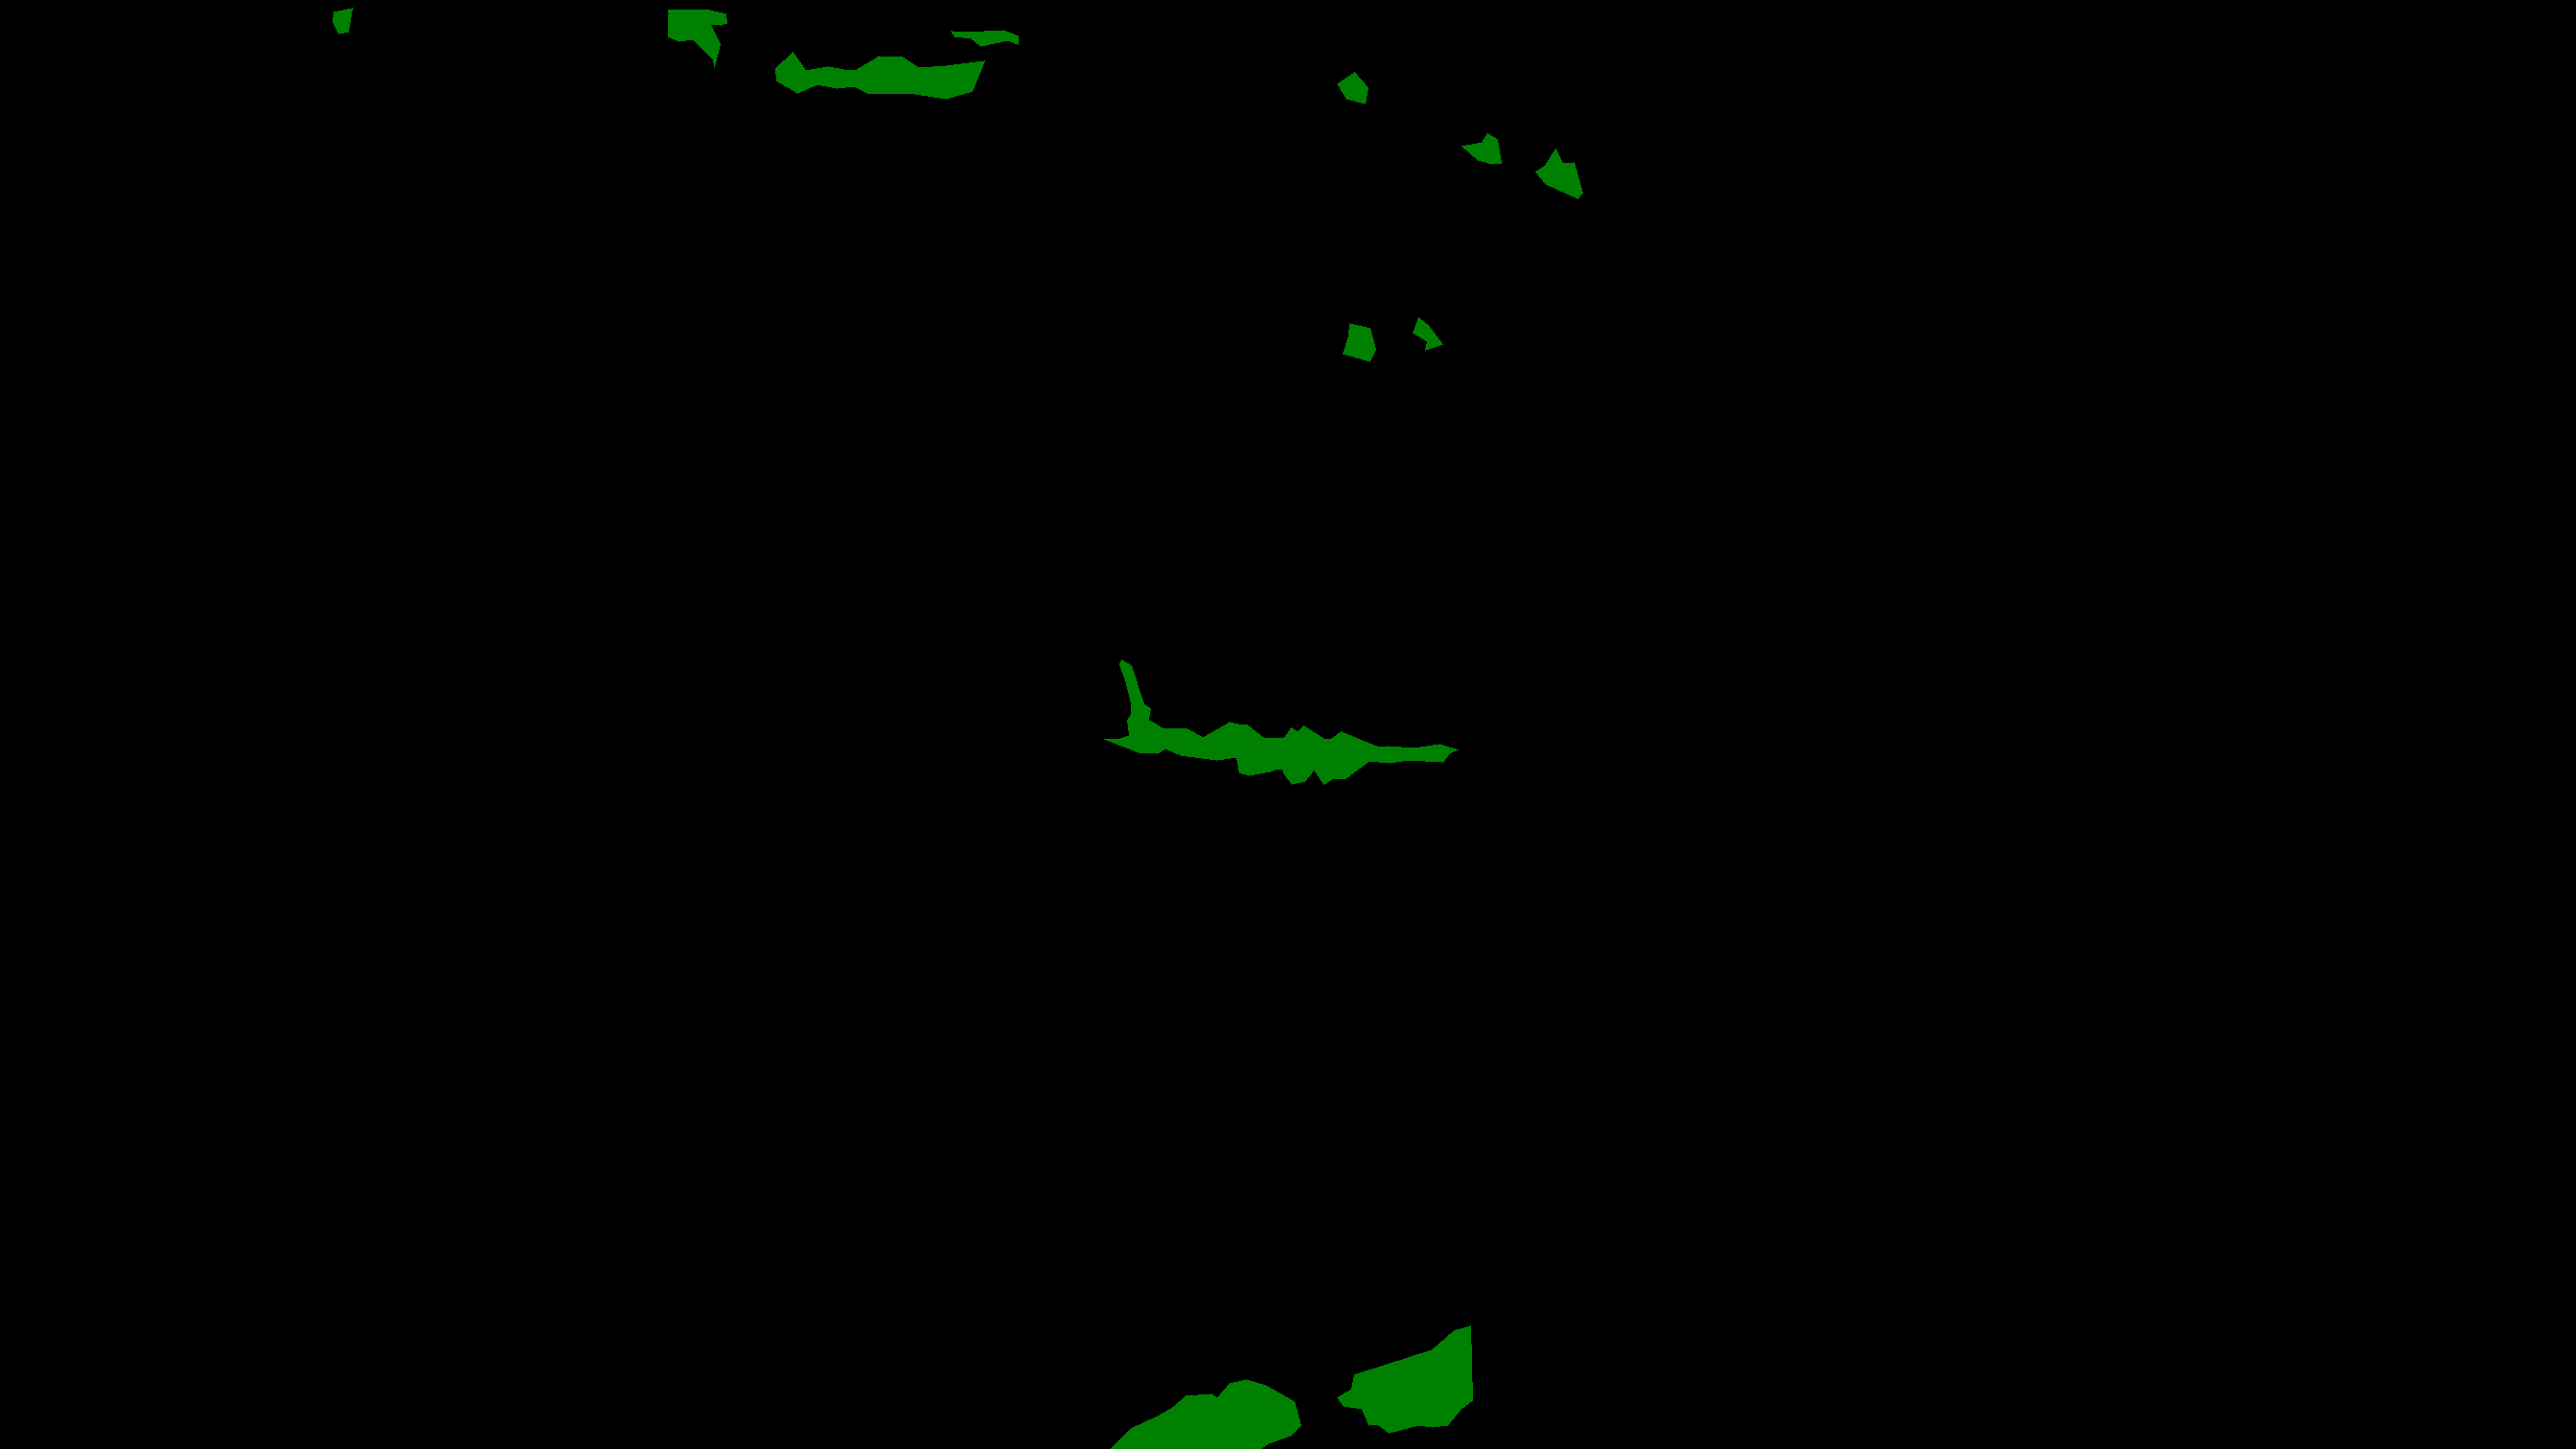

In [2]:
import imgviz
from PIL import Image
import numpy as np
import os

def colored_mask(mask, save_path=None):
    lbl_pil = Image.fromarray(mask.astype(np.uint8), mode="P")
    colormap = imgviz.label_colormap()
    # print(colormap, type(colormap), colormap.flatten(), colormap.shape)
    lbl_pil.putpalette(colormap.flatten())
    if save_path is not None:
        lbl_pil.save(save_path)

    return lbl_pil 


mask_dir = rf'D:\project\code\from_git\image-to-3d-tradition-sfm\3DGS\2d-gaussian-splatting-main_self\tools\mask_img_cls_sample'

want_cls = '0032_2'

mask_total = []
for file in os.listdir(mask_dir):
    # file_cls = file.split('_')[-2]
    # if file_cls == want_cls:
    if want_cls in file:
        mask_pil = Image.open(os.path.join(mask_dir, file))
        mask_np = np.array(mask_pil)
        mask_total.append(mask_np)

mask_total = np.array(mask_total)
mask_total_new = mask_total.sum(axis=0)
print(mask_total_new.shape)

mask_total_new_pil = colored_mask(mask_total_new)
mask_total_new_pil

## demo

In [14]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial import KDTree

def calculate_max_crack_width(all_points=None, A_points=None, B_points=None, interval_d=1.0, cluster_method='kmeans'):
    """
    计算三维裂缝的最大宽度及按间隔计算的宽度列表
    
    参数：
    - all_points: 未分类的三维裂缝点集（若无A/B点集需聚类时使用）
    - A_points, B_points: 预分类的裂缝边界点集（优先使用）
    - interval_d: 区段间隔（单位与点坐标相同）
    - cluster_method: 聚类方法（默认K-Means）
    
    返回：
    - max_width: 最大裂缝宽度
    - section_widths: 各区间段的裂缝宽度列表
    """
    # Step 1: 处理输入数据
    if (A_points is not None) and (B_points is not None):
        pass  # 直接使用预分类的边界点
    else:
        if all_points is None:
            raise ValueError("必须提供all_points或A_points/B_points")
        # 聚类分边界（以K-Means为例）
        kmeans = KMeans(n_clusters=2, random_state=0)
        labels = kmeans.fit_predict(all_points)
        A_points = all_points[labels == 0]
        B_points = all_points[labels == 1]
    
    # Step 2: 确定裂缝主方向
    combined_points = np.vstack((A_points, B_points))
    pca = PCA(n_components=3)
    pca.fit(combined_points)
    main_direction = pca.components_[0]
    main_direction /= np.linalg.norm(main_direction)  # 单位化
    
    # Step 3: 沿主方向投影并划分区段
    t_A = np.dot(A_points, main_direction)
    t_B = np.dot(B_points, main_direction)
    min_t = min(t_A.min(), t_B.min())
    max_t = max(t_A.max(), t_B.max())
    t_steps = np.arange(min_t, max_t + interval_d, interval_d)
    sections = [(t_steps[i], t_steps[i+1]) for i in range(len(t_steps)-1)]
    
    # Step 4: 计算每个区段的裂缝宽度
    section_widths = []
    for start, end in sections:
        # 筛选当前区段的点
        mask_A = (t_A >= start) & (t_A < end)
        mask_B = (t_B >= start) & (t_B < end)
        points_A = A_points[mask_A]
        points_B = B_points[mask_B]
        
        if len(points_A) == 0 or len(points_B) == 0:
            section_widths.append(0.0)
            continue
        
        # 构造垂直于主方向的平面基向量
        axis = np.array([1, 0, 0])
        if np.abs(np.dot(main_direction, axis)) > 0.99:
            axis = np.array([0, 1, 0])
        u = np.cross(main_direction, axis)
        u /= np.linalg.norm(u)
        w = np.cross(main_direction, u)
        w /= np.linalg.norm(w)
        
        # 投影到二维平面
        proj_A = np.dot(points_A, np.column_stack((u, w)))
        proj_B = np.dot(points_B, np.column_stack((u, w)))
        
        # 计算最小距离
        tree = KDTree(proj_B)
        distances, _ = tree.query(proj_A)
        min_dist = np.min(distances)
        section_widths.append(min_dist)
    
    # Step 5: 计算最大宽度
    max_width = max(section_widths)
    return max_width, section_widths

# 示例用法
if __name__ == "__main__":
    # 生成模拟数据（两边界沿Z轴延伸，水平间隔1.0）
    np.random.seed(42)
    n = 500
    z = np.linspace(0, 10, n)
    A_points = np.column_stack((
        np.random.normal(0, 0.1, n),
        np.random.normal(0, 0.1, n),
        z
    ))
    B_points = np.column_stack((
        np.random.normal(1.0, 0.1, n),
        np.random.normal(0, 0.1, n),
        z + np.random.normal(0, 0.11, n)
    ))
    all_points = np.vstack((A_points, B_points))
    
    # 计算宽度（区间间隔1.0）
    max_width, widths = calculate_max_crack_width(all_points=all_points, interval_d=1.0)
    
    print(f"最大裂缝宽度：{max_width:.2f}")
    print(f"前5个区段宽度：{[round(w,2) for w in widths[:5]]}")

最大裂缝宽度：0.00
前5个区段宽度：[0.0, 0.0, 0.0, 0.0, 0.0]


In [18]:
import numpy as np
import open3d as o3d
from scipy.spatial import KDTree, cKDTree
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import trimesh
import time

class CrackWidthAnalyzer:
    def __init__(self, points, segment_length=0.5, min_points=50):
        """
        初始化裂缝分析器
        :param points: 裂缝点云数据，形状为(N, 3)的numpy数组
        :param segment_length: 沿裂缝长度方向的分段长度
        :param min_points: 每个分段的最小点数
        """
        self.original_points = np.asarray(points, dtype=np.float64)
        self.segment_length = segment_length
        self.min_points = min_points
        self.crack_axis = 'x'  # 默认裂缝主轴
        self.segments = []
        self.segment_results = []
        self.global_max_width = 0
        self.global_max_location = None
        
        # 预处理点云
        self._preprocess_points()
        
        # 确定裂缝主轴
        self._determine_crack_axis()
        
        # 沿裂缝长度方向分段
        self._segment_crack()
    
    def _preprocess_points(self):
        """点云预处理：去噪、降采样"""
        # 创建点云对象
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(self.original_points)
        
        # 统计离群点去除
        cl, _ = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
        
        # 体素降采样
        bbox = pcd.get_axis_aligned_bounding_box()
        bbox_size = bbox.get_extent()
        voxel_size = np.min(bbox_size) * 0.05
        downsampled = cl.voxel_down_sample(voxel_size=voxel_size)
        
        self.points = np.asarray(downsampled.points)
        print(f"预处理完成: 原始点数 {len(self.original_points)} -> 处理后点数 {len(self.points)}")
    
    def _determine_crack_axis(self):
        """使用PCA确定裂缝主轴方向"""
        pca = PCA(n_components=3)
        pca.fit(self.points)
        
        # 主成分解释的方差
        explained_variance = pca.explained_variance_ratio_
        
        # 确定主轴方向 (X=0, Y=1, Z=2)
        if explained_variance[0] > 0.7:  # 如果第一个主成分解释大部分方差
            self.crack_axis = 'x'
        elif explained_variance[1] > 0.7:
            self.crack_axis = 'y'
        else:
            self.crack_axis = 'z'
        
        print(f"确定裂缝主轴方向: {self.crack_axis} (解释方差: {explained_variance})")
    
    def _segment_crack(self):
        """沿裂缝长度方向分段"""
        # 获取沿主轴方向的投影值
        if self.crack_axis == 'x':
            proj_values = self.points[:, 0]
        elif self.crack_axis == 'y':
            proj_values = self.points[:, 1]
        else:  # 'z'
            proj_values = self.points[:, 2]
        
        min_val = np.min(proj_values)
        max_val = np.max(proj_values)
        
        # 计算分段数量
        num_segments = int(np.ceil((max_val - min_val) / self.segment_length))
        print(f"沿裂缝长度方向创建 {num_segments} 个分段 (分段长度: {self.segment_length})")
        
        # 创建分段
        for i in range(num_segments):
            seg_start = min_val + i * self.segment_length
            seg_end = seg_start + self.segment_length
            
            # 获取分段内的点
            mask = (proj_values >= seg_start) & (proj_values < seg_end)
            seg_points = self.points[mask]
            
            # 如果点数足够，添加到分段列表
            if len(seg_points) >= self.min_points:
                segment = {
                    'id': i,
                    'start': seg_start,
                    'end': seg_end,
                    'center': (seg_start + seg_end) / 2,
                    'points': seg_points
                }
                self.segments.append(segment)
        
        print(f"有效分段数: {len(self.segments)} (每个分段至少 {self.min_points} 个点)")
    
    def analyze_segments(self, method='point_to_mesh', visualize=False):
        """分析每个分段内的裂缝宽度"""
        start_time = time.time()
        self.segment_results = []
        all_max_widths = []
        
        for segment in self.segments:
            seg_id = segment['id']
            seg_points = segment['points']
            
            # 分割裂缝壁面
            wall1, wall2 = self._segment_walls(seg_points)
            
            # 重建表面
            wall1_mesh = self._reconstruct_surface(wall1)
            wall2_mesh = self._reconstruct_surface(wall2)
            
            # 计算裂缝宽度
            if method == 'point_to_mesh':
                widths = self._calculate_point_to_mesh_widths(wall1, wall2_mesh)
            elif method == 'ray_casting':
                widths = self._calculate_ray_casting_widths(wall1, wall2_mesh)
            else:
                raise ValueError(f"未知宽度计算方法: {method}")
            
            # 计算分段统计
            seg_max_width = np.max(widths)
            max_idx = np.argmax(widths)
            max_location = wall1[max_idx]
            mean_width = np.mean(widths)
            
            # 存储结果
            result = {
                'segment_id': seg_id,
                'start': segment['start'],
                'end': segment['end'],
                'center': segment['center'],
                'num_points': len(seg_points),
                'max_width': seg_max_width,
                'mean_width': mean_width,
                'max_location': max_location,
                'widths': widths
            }
            self.segment_results.append(result)
            all_max_widths.append(seg_max_width)
            
            # 更新全局最大值
            if seg_max_width > self.global_max_width:
                self.global_max_width = seg_max_width
                self.global_max_location = max_location
        
        # 计算全局统计
        global_mean = np.mean([r['mean_width'] for r in self.segment_results])
        
        elapsed = time.time() - start_time
        print(f"分段分析完成: 共 {len(self.segment_results)} 个分段")
        print(f"全局最大宽度: {self.global_max_width:.6f}, 平均宽度: {global_mean:.6f}")
        print(f"总耗时: {elapsed:.2f} 秒")
        
        if visualize:
            self._visualize_results()
    
    def _segment_walls(self, points):
        """分割裂缝壁面"""
        # 沿裂缝宽度方向投影
        if self.crack_axis == 'x':  # 主轴是X，则宽度方向可能是Y或Z
            proj_values = points[:, 1]  # 使用Y方向
        elif self.crack_axis == 'y':
            proj_values = points[:, 2]  # 使用Z方向
        else:  # 'z'
            proj_values = points[:, 0]  # 使用X方向
        
        # 自动确定分割阈值
        from skimage.filters import threshold_otsu
        thresh = threshold_otsu(proj_values)
        
        # 分割点云
        wall1_mask = proj_values < thresh
        wall2_mask = proj_values >= thresh
        
        return points[wall1_mask], points[wall2_mask]
    
    def _reconstruct_surface(self, points):
        """重建表面网格"""
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)
        
        # 估计法向量
        pcd.estimate_normals()
        
        # 使用泊松重建
        mesh, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8)
        
        return mesh
    
    def _calculate_point_to_mesh_widths(self, wall1_points, wall2_mesh):
        """点对网格方法计算宽度"""
        # 将壁面2网格转换为trimesh对象
        wall2_trimesh = trimesh.Trimesh(
            vertices=np.asarray(wall2_mesh.vertices),
            faces=np.asarray(wall2_mesh.triangles)
        )
        
        # 计算壁面1上每个点到壁面2表面的距离
        widths, _, _ = wall2_trimesh.nearest.on_surface(wall1_points)
        
        return np.abs(widths)
    
    def _calculate_ray_casting_widths(self, wall1_points, wall2_mesh):
        """射线投射方法计算宽度"""
        # 将壁面2网格转换为trimesh对象
        wall2_trimesh = trimesh.Trimesh(
            vertices=np.asarray(wall2_mesh.vertices),
            faces=np.asarray(wall2_mesh.triangles)
        )
        
        # 计算壁面1在每个点的法向量
        tree = KDTree(wall1_points)
        normals = []
        
        for point in wall1_points:
            # 找到最近的几个点
            dists, indices = tree.query(point, k=10)
            neighbors = wall1_points[indices]
            
            # PCA计算法向量
            pca = PCA(n_components=3)
            pca.fit(neighbors)
            normal = pca.components_[2]  # 最小特征值对应的特征向量
            normals.append(normal)
        
        normals = np.array(normals)
        
        # 计算裂缝宽度
        widths = []
        for point, normal in zip(wall1_points, normals):
            # 创建射线
            ray_origin = point
            ray_direction = normal
            
            # 计算射线与壁面2的交点
            locations, _, _ = wall2_trimesh.ray.intersects_location(
                ray_origins=[ray_origin],
                ray_directions=[ray_direction]
            )
            
            if len(locations) > 0:
                # 找到最近交点
                dists = np.linalg.norm(locations - ray_origin, axis=1)
                width = np.min(dists)
                widths.append(width)
            else:
                # 如果没有交点，使用点对网格方法
                dist, _, _ = wall2_trimesh.nearest.on_surface([point])
                widths.append(np.abs(dist[0]))
        
        return np.array(widths)
    
    def _visualize_results(self):
        """可视化分析结果"""
        fig = plt.figure(figsize=(18, 12))
        
        # 1. 裂缝宽度沿长度变化
        ax1 = fig.add_subplot(221)
        centers = [r['center'] for r in self.segment_results]
        max_widths = [r['max_width'] for r in self.segment_results]
        mean_widths = [r['mean_width'] for r in self.segment_results]
        
        ax1.plot(centers, max_widths, 'ro-', label='最大宽度')
        ax1.plot(centers, mean_widths, 'bs-', label='平均宽度')
        ax1.set_title('裂缝宽度沿长度变化')
        ax1.set_xlabel('裂缝位置')
        ax1.set_ylabel('宽度')
        ax1.grid(True)
        ax1.legend()
        
        # 2. 最大宽度位置标记
        ax2 = fig.add_subplot(222, projection='3d')
        
        # 绘制所有裂缝点
        ax2.scatter(self.points[:, 0], self.points[:, 1], self.points[:, 2], 
                   c='gray', s=5, alpha=0.3, label='裂缝点')
        
        # 标记每个分段的最大宽度位置
        for result in self.segment_results:
            loc = result['max_location']
            ax2.scatter(loc[0], loc[1], loc[2], c='red', s=50, alpha=0.7)
        
        # 标记全局最大宽度位置
        ax2.scatter(self.global_max_location[0], self.global_max_location[1], self.global_max_location[2],
                   c='blue', s=200, marker='*', label='全局最大宽度')
        
        ax2.set_title('最大宽度位置分布')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('Z')
        ax2.legend()
        
        # 3. 宽度分布直方图
        ax3 = fig.add_subplot(223)
        all_widths = np.concatenate([r['widths'] for r in self.segment_results])
        ax3.hist(all_widths, bins=50, color='skyblue', edgecolor='black')
        ax3.set_title('裂缝宽度分布直方图')
        ax3.set_xlabel('宽度')
        ax3.set_ylabel('频率')
        ax3.axvline(self.global_max_width, color='r', linestyle='dashed', 
                    linewidth=1, label=f'全局最大宽度: {self.global_max_width:.4f}')
        ax3.legend()
        
        # 4. 统计信息
        ax4 = fig.add_subplot(224)
        ax4.axis('off')
        
        # 计算全局统计
        global_mean = np.mean([r['mean_width'] for r in self.segment_results])
        global_median = np.median(all_widths)
        global_std = np.std(all_widths)
        
        stats_text = (
            f"全局最大宽度: {self.global_max_width:.6f}\n"
            f"全局平均宽度: {global_mean:.6f}\n"
            f"宽度中位数: {global_median:.6f}\n"
            f"宽度标准差: {global_std:.6f}\n"
            f"最大宽度位置: ({self.global_max_location[0]:.4f}, "
            f"{self.global_max_location[1]:.4f}, {self.global_max_location[2]:.4f})\n\n"
            f"分析参数:\n"
            f"  分段长度: {self.segment_length}\n"
            f"  分段数量: {len(self.segment_results)}\n"
            f"  处理点数: {len(self.points)}"
        )
        
        ax4.text(0.05, 0.5, stats_text, fontsize=12, family='monospace')
        
        plt.tight_layout()
        plt.show()
    
    def generate_report(self):
        """生成分析报告"""
        report = "===== 裂缝宽度分析报告 =====\n\n"
        report += f"全局统计:\n"
        report += f"  全局最大宽度: {self.global_max_width:.6f}\n"
        
        # 计算全局统计
        all_widths = np.concatenate([r['widths'] for r in self.segment_results])
        global_mean = np.mean(all_widths)
        global_median = np.median(all_widths)
        global_std = np.std(all_widths)
        
        report += f"  全局平均宽度: {global_mean:.6f}\n"
        report += f"  宽度中位数: {global_median:.6f}\n"
        report += f"  宽度标准差: {global_std:.6f}\n"
        report += f"  最大宽度位置: ({self.global_max_location[0]:.4f}, "
        report += f"{self.global_max_location[1]:.4f}, {self.global_max_location[2]:.4f})\n\n"
        
        report += f"分段统计:\n"
        report += "Segment | Start | End   | Points | Max Width | Mean Width | Max Location\n"
        report += "--------|-------|-------|--------|-----------|------------|-------------\n"
        
        for result in self.segment_results:
            loc = result['max_location']
            report += (
                f"{result['segment_id']:7d} | "
                f"{result['start']:.2f} | "
                f"{result['end']:.2f} | "
                f"{result['num_points']:6d} | "
                f"{result['max_width']:.6f} | "
                f"{result['mean_width']:.6f} | "
                f"({loc[0]:.2f}, {loc[1]:.2f}, {loc[2]:.2f})\n"
            )
        
        return report

def generate_sample_crack_points(length=10, width=0.5, height=2, num_points=5000, 
                                max_width=0.8, min_width=0.1, noise_level=0.02,
                                curvature=0.1):
    """
    生成样本裂缝点云（带宽度变化和曲率）
    :param length: 裂缝长度
    :param width: 平均裂缝宽度
    :param height: 裂缝高度
    :param num_points: 总点数
    :param max_width: 裂缝最大宽度
    :param min_width: 裂缝最小宽度
    :param noise_level: 噪声水平
    :param curvature: 裂缝曲率
    :return: 裂缝点云数组
    """
    np.random.seed(42)
    
    # 生成裂缝主轴位置
    positions = np.random.rand(num_points) * length
    
    # 生成裂缝宽度变化 (正弦变化)
    widths = min_width + (max_width - min_width) * (np.sin(positions * 2 * np.pi / length) + 1) / 2
    
    # 添加曲率效果
    curve_offset = curvature * np.sin(positions * 2 * np.pi / length)
    
    # 生成壁面1的点
    wall1_points = np.zeros((num_points, 3))
    wall1_points[:, 0] = positions  # 裂缝主轴方向
    wall1_points[:, 1] = np.random.rand(num_points) * height  # 裂缝高度方向
    wall1_points[:, 2] = -widths / 2 + curve_offset  # 裂缝宽度方向
    
    # 生成壁面2的点
    wall2_points = np.zeros((num_points, 3))
    wall2_points[:, 0] = positions
    wall2_points[:, 1] = np.random.rand(num_points) * height
    wall2_points[:, 2] = widths / 2 + curve_offset
    
    # 合并点云
    points = np.vstack([wall1_points, wall2_points])
    
    # 添加噪声
    points += noise_level * np.random.randn(*points.shape)
    
    # 添加随机旋转
    angle = np.random.uniform(0, 2*np.pi)
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]
    ])
    points = points @ rotation_matrix
    
    return points

# 主程序
if __name__ == "__main__":
    # 生成样本裂缝点云（带宽度变化和曲率）
    crack_points = generate_sample_crack_points(
        length=5, 
        width=0.5, 
        height=2, 
        num_points=3000,
        max_width=0.8,
        min_width=0.1,
        noise_level=0.01,
        curvature=0.2
    )
    
    # 初始化裂缝分析器（设置分段长度为0.5）
    analyzer = CrackWidthAnalyzer(crack_points, segment_length=0.5)
    
    # 分析每个分段内的裂缝宽度
    # analyzer.analyze_segments(method='point_to_mesh', visualize=True)
    analyzer.analyze_segments(method='ray_casting', visualize=True)
    
    # 生成分析报告
    report = analyzer.generate_report()
    print(report)
    
    # 保存结果
    # np.savetxt("crack_points.csv", crack_points, delimiter=",")
    
    # 保存分段结果
    segment_data = []
    for result in analyzer.segment_results:
        segment_data.append([
            result['segment_id'],
            result['start'],
            result['end'],
            result['center'],
            result['num_points'],
            result['max_width'],
            result['mean_width'],
            result['max_location'][0],
            result['max_location'][1],
            result['max_location'][2]
        ])
    
    segment_header = "segment_id,start,end,center,num_points,max_width,mean_width,max_x,max_y,max_z"
    # np.savetxt("crack_segment_results.csv", segment_data, delimiter=",", 
    #           header=segment_header, comments="", fmt='%d,%.4f,%.4f,%.4f,%d,%.6f,%.6f,%.4f,%.4f,%.4f')
    
    print("分析结果已保存")

预处理完成: 原始点数 6000 -> 处理后点数 4675
确定裂缝主轴方向: x (解释方差: [0.84569658 0.12542125 0.02888217])
沿裂缝长度方向创建 5 个分段 (分段长度: 0.5)
有效分段数: 5 (每个分段至少 50 个点)


C:\Users\1\AppData\Local\Temp\ipykernel_32576\1026109226.py:267: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(widths)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()